# Lecture : Graph SVM

## Lab 02 : Soft-Margin SVM -- Exercise

### Xavier Bresson, Guoji Fu 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/04_Graph_SVM'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd


In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
from lib.utils import compute_SVM
import warnings; warnings.filterwarnings("ignore")


# Linearly separable data points

In [3]:
# Data matrix X = linearly separable data points
mat = scipy.io.loadmat('datasets/data_softSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


40 2 2


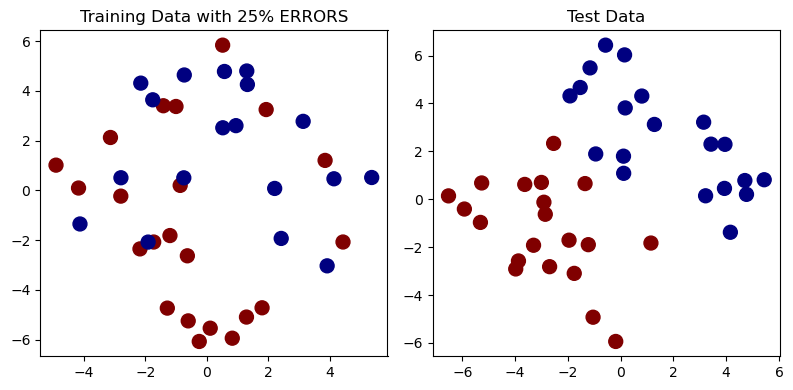

In [4]:
# Plot
plt.figure(figsize=(8,4))
p1 = plt.subplot(121)
size_vertex_plot = 100
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data with 25% ERRORS')
p2 = plt.subplot(122)
size_vertex_plot = 100
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.tight_layout()
plt.show()


### Question 1: Evaluate the performance of soft-margin SVM on linearly separable data with different error parameters

How does the performance of a soft-margin SVM change on training and testing data as the error parameter increases?

Answer:  


In [5]:
# Error parameter
############################################################################
# Your code start
############################################################################

lamb = 0.01 # 92.5
lamb = 0.1 # 97.5

############################################################################
# Your code end
############################################################################


### Question 2: Project $\alpha$ to $[0, \lambda]$ during the update of alpha and beta with conjuguate gradient.


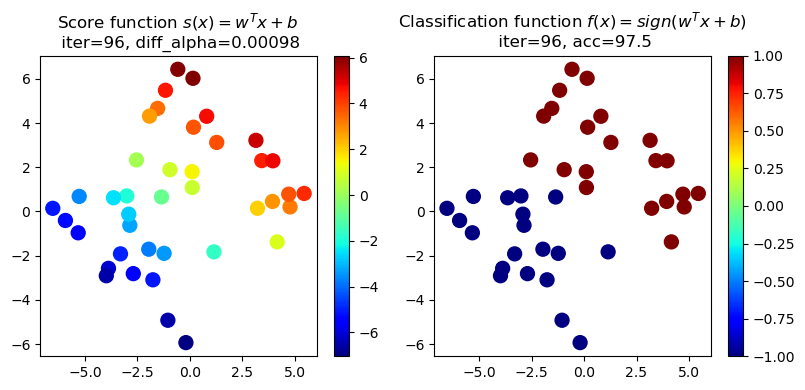

In [6]:
# Run soft-margin SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Initialization
alpha = np.zeros([n])
beta = np.ones([n])
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)  
    
    # Projection of alpha on [0, \lambda]
    ############################################################################
    # Your code start
    ############################################################################

    # These two lines represent min [0 <= alpha <= lambda]
    alpha[alpha < 0] = 0
    alpha[alpha > lamb] = lamb

    ############################################################################
    # Your code end
    ############################################################################

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        plt.figure(figsize=(8,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        

# Non-linearly separable data points

In [7]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_softSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['C_train_errors'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print(n,d,nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()


500 100 2


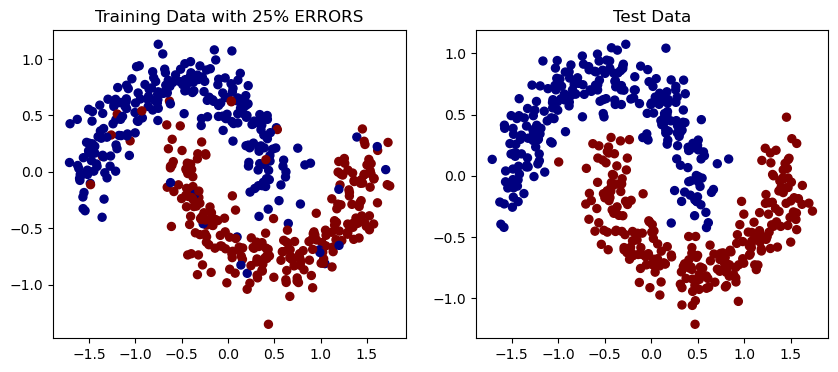

In [8]:
# Plot
plt.figure(figsize=(10,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_train, color=pyplot.jet())
plt.title('Training Data with 25% ERRORS')
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
#plt.tight_layout()
plt.show()


### Question 3: Evaluate the performance of soft-margin SVM on non-linearly separable data with different error parameters

Compare the results with hard-margin Linear SVM, can significant improvements in soft-margin linear SVM over hard-margin linear SVM be achieved by tuning the error parameter on non-linearly separable data?

Answer: 
 

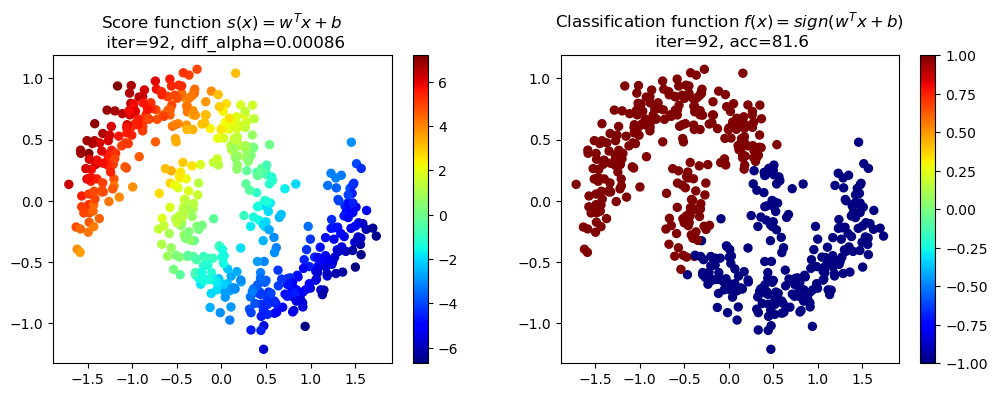

In [9]:
# Run soft-margin SVM

# Compute linear kernel, L, Q
Ker = Xtrain.dot(Xtrain.T)
l = l_train
L = np.diag(l)
Q = L.dot(Ker.dot(L))

# Time steps
tau_alpha = 10/ np.linalg.norm(Q,2)
tau_beta = 0.1/ np.linalg.norm(L,2)

# For conjuguate gradient
Acg = tau_alpha* Q + np.eye(n)

# Pre-compute J.K(Xtest) for test data
LKXtest = L.dot(Xtrain.dot(Xtest.T))

# Error parameter
############################################################################
# Your code start
############################################################################

lamb = 0.85

############################################################################
# Your code end
############################################################################

# Initialization
alpha = np.zeros([n])
beta = 0.0
alpha_old = alpha

# Loop
k = 0
diff_alpha = 1e6
num_iter = 201
while (diff_alpha>1e-3) & (k<num_iter):
    
    # Update iteration
    k += 1
    
    # Update alpha
    # Approximate solution with conjuguate gradient
    b0 = alpha + tau_alpha - tau_alpha* l* beta
    alpha, _ = scipy.sparse.linalg.cg(Acg, b0, x0=alpha, tol=1e-3, maxiter=50)   
    alpha[alpha<0.0] = 0 # Projection on [0,+infty]
    alpha[alpha>lamb] = lamb # Projection on [-infty,lamb]

    # Update beta
    beta = beta + tau_beta* l.T.dot(alpha)
    
    # Stopping condition
    diff_alpha = np.linalg.norm(alpha-alpha_old)
    alpha_old = alpha
    
    # Plot
    if not(k%10) or (diff_alpha<1e-3):
           
        # Indicator function of support vectors
        idx = np.where( np.abs(alpha)>0.25* np.max(np.abs(alpha)) )
        Isv = np.zeros([n]); Isv[idx] = 1
        nb_sv = len(Isv.nonzero()[0])
        
        # Offset
        if nb_sv > 1:
            b = (Isv.T).dot( l - Ker.dot(L.dot(alpha)) )/ nb_sv
        else:
            b = 0
            
        # Continuous score function
        f_test = alpha.T.dot(LKXtest) + b 

        # Binary classification function
        C_test = np.sign(f_test) # decision function in {-1,1}
        accuracy_test = compute_purity(0.5*(1+C_test),Cgt_test,nc) # 0.5*(1+C_test) in {0,1}

        # Plot
        size_vertex_plot = 33
        plt.figure(figsize=(12,4))
        p1 = plt.subplot(121)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=f_test, color=pyplot.jet())
        plt.title('Score function $s(x)=w^Tx+b$ \n iter=' + str(k)+ ', diff_alpha=' + str(diff_alpha)[:7])
        plt.colorbar()
        p2 = plt.subplot(122)
        plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=C_test, color=pyplot.jet())
        plt.title('Classification function $f(x)=sign(w^Tx+b)$\n iter=' + str(k) + ', acc=' + str(accuracy_test)[:5])
        #plt.tight_layout()
        plt.colorbar()
        plt.show()
        if k<num_iter-1:
            clear_output(wait=True)   
        